In [1]:
from torch import nn
import os
import pandas as pd
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import os
%matplotlib inline

In [2]:
os.getcwd()

'C:\\Users\\danie\\Documents'

### Preparing the Data

In [3]:
path2csv="./data/train_labels.csv"
labels_df=pd.read_csv(path2csv)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
print(labels_df['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64


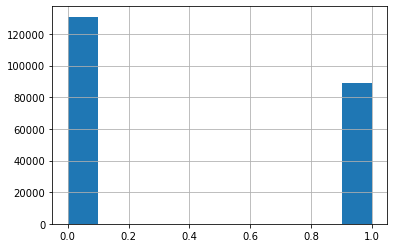

In [5]:
%matplotlib inline
labels_df['label'].hist();

In [6]:
# get ids for malignant images
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

In [7]:
# data is stored here
path2train="./data/train/"

In [8]:
# show images in grayscale, if you want color change it to True
color=False

In [9]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows,ncols=3,3

<Figure size 720x720 with 0 Axes>

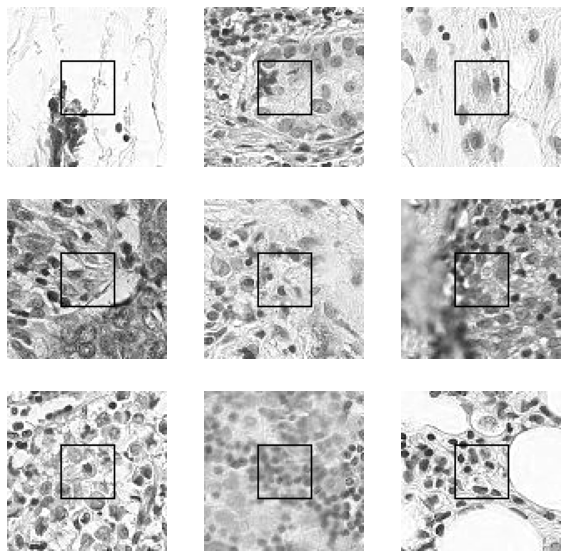

In [10]:
for i,id_ in enumerate(malignantIds[:nrows*ncols]):
    full_filenames = os.path.join(path2train , id_ +'.tif')
 
    # load image
    img = Image.open(full_filenames)

    # draw a 32*32 rectangle 
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32, 32), (64, 64)),outline="green")
    plt.subplot(nrows, ncols, i+1) 
    if color is True:
        plt.imshow(np.array(img))
    else:
        plt.imshow(np.array(img)[:,:,0],cmap="gray")
    plt.axis('off')

In [11]:
print("image shape:", np.array(img).shape)
print("pixel values range from %s to %s" %(np.min(img), np.max(img)))

image shape: (96, 96, 3)
pixel values range from 0 to 255


### Creating a Custom Dataset

In [12]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms
import os

In [13]:
# fix torch random seed
torch.manual_seed(0)

In [14]:
class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform,data_type="train"):      
    
        # path to images
        path2data=os.path.join(data_dir,data_type)

        # get a list of images
        filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # labels are in a csv file named train_labels.csv
        csv_filename=data_type+"_labels.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index("id", inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]

        self.transform = transform
        
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [15]:
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])

In [16]:
data_dir = "./data/"
histo_dataset = histoCancerDataset(data_dir, data_transformer, "train")
print(len(histo_dataset))

220025


In [17]:
# load an image
img, label = histo_dataset[9]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


### Splitting the Dataset

In [18]:
from torch.utils.data import random_split

len_histo=len(histo_dataset)
len_train=int(0.8*len_histo)
len_val=len_histo-len_train

train_ds,val_ds=random_split(histo_dataset,[len_train,len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))

train dataset length: 176020
validation dataset length: 44005


In [19]:
for x,y in train_ds:
    print(x.shape,y)
    break

torch.Size([3, 96, 96]) 1


In [20]:
for x,y in val_ds:
    print(x.shape,y)
    break

torch.Size([3, 96, 96]) 1


In [21]:
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

In [22]:
def show(img,y,color=False):
    # convert tensor to numpy array
    npimg = img.numpy()
   
    # Convert to H*W*C shape
    npimg_tr=np.transpose(npimg, (1,2,0))
    
    if color==False:
        npimg_tr=npimg_tr[:,:,0]
        plt.imshow(npimg_tr,interpolation='nearest',cmap="gray")
    else:
        # display images
        plt.imshow(npimg_tr,interpolation='nearest')
    plt.title("label: "+str(y))

In [23]:
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ds[i][0] for i in rnd_inds]
y_grid_train=[train_ds[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)

image indices: [ 43567 173685 117952 152315]
torch.Size([3, 100, 394])


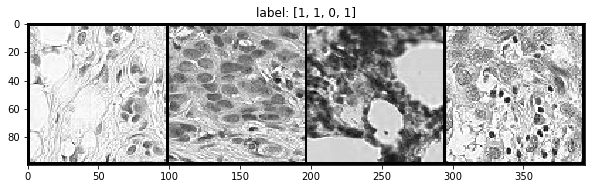

In [24]:
plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train,y_grid_train)

image indices: [30403 32103 41993 20757]
torch.Size([3, 100, 394])


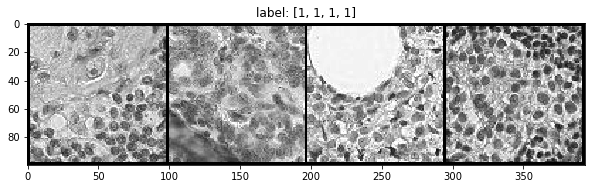

In [25]:
grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ds[i][0] for i in range(grid_size)]
y_grid_val=[val_ds[i][1] for i in range(grid_size)]

x_grid_val=utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)

show(x_grid_val,y_grid_val)

### Transforming the Data

In [26]:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
    transforms.RandomResizedCrop(96,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor()])

val_transformer = transforms.Compose([transforms.ToTensor()])

In [27]:
# overwrite the transform functions
train_ds.transform=train_transformer
val_ds.transform=val_transformer

### Creating Dataloaders
We are ready to create a PyTorch dataloader. If we do not use dataloaders, we have to write code to loop over datasets and extract a data batch. This process can be made automatically using a PyTorch Dataloader.

In [28]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

In [29]:
# extract a batch from training data
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break
torch.Size([32, 3, 96, 96])
torch.Size([32])

torch.Size([32, 3, 96, 96])
torch.Size([32])


torch.Size([32])

In [30]:
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 3, 96, 96])
torch.Size([64])


### Building the Classification Model
In this section, we will build a model for our binary classification task. Our model is comprised of four convolutional neural networks (CNNs) and two fully connected layers, as shown in the following diagram.

In [31]:
# get labels for validation dataset
y_val=[y for _,y in val_ds]   

In [32]:
def accuracy(labels, out):
    return np.sum(out==labels)/float(len(labels))

In [33]:
# accuracy all zero predictions
acc_all_zeros=accuracy(y_val,np.zeros_like(y_val))
print("accuracy all zero prediction: %.2f" %acc_all_zeros)

accuracy all zero prediction: 0.59


In [34]:
# accuracy random predictions
acc_random=accuracy(y_val,np.random.randint(2,size=len(y_val)))

print("accuracy random prediction: %.2f" %acc_random)

accuracy random prediction: 0.50


In [35]:
import torch.nn as nn
import numpy as np
import torch

In [36]:
def findConv2dOutShape(H_in,W_in,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    # Ref: https://pytorch.org/docs/stable/nn.html
    H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out=np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        H_out/=pool
        W_out/=pool
    return int(H_out),int(W_out)

In [37]:
# example
conv1 = nn.Conv2d(3, 8, kernel_size=3)
h,w=findConv2dOutShape(96,96,conv1)
print(h,w)

47 47


In [38]:
import torch.nn as nn
import torch.nn.functional as F

In [39]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
        C_in, H_in, W_in = params["input_shape"]
        init_f = params["initial_filters"] 
        num_fc1 = params["num_fc1"]  
        num_classes = params["num_classes"] 
        self.dropout_rate = params["dropout_rate"]
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h,w=findConv2dOutShape(H_in,W_in,self.conv1)
        
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)

        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.num_flatten)
        x = F.relu(self.fc1(x))
        x=F.dropout(x, self.dropout_rate, training= self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

The dropout layer is only applied during training. At deployment, the dropout layer should be deactivated. To do so, make sure to set training argument of the dropout layer to False at deployment.

In [40]:
# dict to define model parameters
params_model={
        "input_shape": (3,96,96),
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2,
            }

# create model
cnn_model = Net(params_model)

In [41]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model=cnn_model.to(device)

In [42]:
print(cnn_model)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [43]:
print(next(cnn_model.parameters()).device)

cuda:0


In [44]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 96, 96),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
            Conv2d-2           [-1, 16, 45, 45]           1,168
            Conv2d-3           [-1, 32, 20, 20]           4,640
            Conv2d-4             [-1, 64, 8, 8]          18,496
            Linear-5                  [-1, 100]         102,500
            Linear-6                    [-1, 2]             202
Total params: 127,230
Trainable params: 127,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.92
Params size (MB): 0.49
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


### Defining the Loss Function

In [45]:
loss_func = nn.NLLLoss(reduction="sum")

In [46]:
# fix random seed
torch.manual_seed(0)

n,c=8,2
y = torch.randn(n, c, requires_grad=True)
ls_F = nn.LogSoftmax(dim=1)
y_out=ls_F(y)
print(y_out.shape)

target = torch.randint(c,size=(n,))
print(target.shape)

loss = loss_func(y_out, target)
print(loss.item())

torch.Size([8, 2])
torch.Size([8])
5.266995429992676


In [47]:
loss.backward()
print(y.data)

tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        [-0.3160, -2.1152],
        [ 0.3223, -1.2633],
        [ 0.3500,  0.3081],
        [ 0.1198,  1.2377],
        [ 1.1168, -0.2473]])


### Defining the Optimizer

In [48]:
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)

In [49]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


In [50]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [51]:
for i in range(100):
    lr_scheduler.step(1)

Epoch    22: reducing learning rate of group 0 to 1.5000e-04.
Epoch    43: reducing learning rate of group 0 to 7.5000e-05.
Epoch    64: reducing learning rate of group 0 to 3.7500e-05.
Epoch    85: reducing learning rate of group 0 to 1.8750e-05.


### Training and evaluation of the model

In [52]:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [53]:
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    with torch.no_grad():
        metric_b = metrics_batch(output,target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

In [54]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)

        # get model output
        output=model(xb)

        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)

        # update running loss
        running_loss+=loss_b

        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break

    # average loss value
    loss=running_loss/float(len_data)

    # average metric value
    metric=running_metric/float(len_data)

    return loss, metric

In [55]:
def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],}
    
    # history of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
            }
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
        }
    
    # history of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
     # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())

    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in range(num_epochs):

        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))

        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        # evaluate model on validation dataset
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)


        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")

        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
            print("-"*10)

            # load best model weights
            model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [56]:
import copy
loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [57]:
params_train={
 "num_epochs": 100,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": "./models/weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

Epoch 0/99, current lr=0.0003
Copied best model weights!
Epoch 1/99, current lr=0.0003
Copied best model weights!
Epoch 2/99, current lr=0.0003
Copied best model weights!
Epoch 3/99, current lr=0.0003
Epoch 4/99, current lr=0.0003
Copied best model weights!
Epoch 5/99, current lr=0.0003
Copied best model weights!
Epoch 6/99, current lr=0.0003
Copied best model weights!
Epoch 7/99, current lr=0.0003
Epoch 8/99, current lr=0.0003
Copied best model weights!
Epoch 9/99, current lr=0.0003
Copied best model weights!
Epoch 10/99, current lr=0.0003
Copied best model weights!
Epoch 11/99, current lr=0.0003
Copied best model weights!
Epoch 12/99, current lr=0.0003
Epoch 13/99, current lr=0.0003
Epoch 14/99, current lr=0.0003
Epoch 15/99, current lr=0.0003
Copied best model weights!
Epoch 16/99, current lr=0.0003
Epoch 17/99, current lr=0.0003
Epoch 18/99, current lr=0.0003
Epoch 19/99, current lr=0.0003
Epoch 20/99, current lr=0.0003
Epoch 21/99, current lr=0.0003
Epoch 22/99, current lr=0.0003


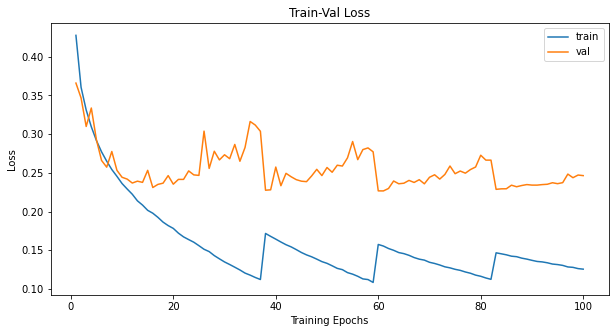

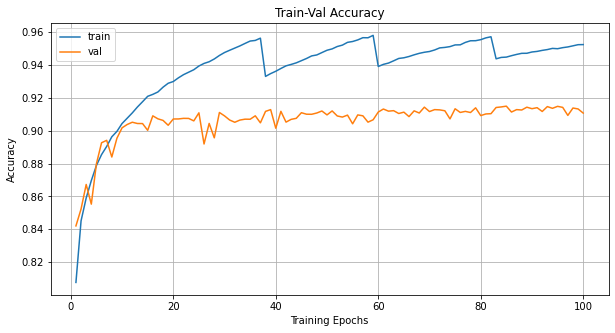

In [58]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid()
plt.show()

### Deploying the model

In [59]:
# model parameters
params_model={
 "input_shape": (3,96,96),
 "initial_filters": 8, 
 "num_fc1": 100,
 "dropout_rate": 0.25,
 "num_classes": 2,
 }

# initialize model
cnn_model = Net(params_model)

In [60]:
# load state_dict into model
path2weights="./models/weights.pt"
cnn_model.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [61]:
# set model in evaluation mode
cnn_model.eval()

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [62]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model=cnn_model.to(device)

In [63]:
def deploy_model(model,dataset,device, num_classes=2,sanity_check=False):

    len_data=len(dataset)
    
    # initialize output tensor on CPU: due to GPU memory limits
    y_out=torch.zeros(len_data,num_classes)
    
    # initialize ground truth on CPU: due to GPU memory limits
    y_gt=np.zeros((len_data),dtype="uint8")
    
    # move model to device
    model=model.to(device)
    
    elapsed_times=[]
    with torch.no_grad():
        for i in range(len_data):
            x,y=dataset[i]
            y_gt[i]=y
            start=time.time()    
            y_out[i]=model(x.unsqueeze(0).to(device))
            elapsed=time.time()-start
            elapsed_times.append(elapsed)

            if sanity_check is True:
                break

    inference_time=np.mean(elapsed_times)*1000
    print("average inference time per image on %s: %.2f ms " %(device,inference_time))
    return y_out.numpy(),y_gt

In [64]:
# deploy model 
y_out,y_gt=deploy_model(cnn_model,val_ds,device=device,sanity_check=False)
print(y_out.shape,y_gt.shape)

NameError: name 'time' is not defined

In [ ]:
from sklearn.metrics import accuracy_score

# get predictions
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)

# compute accuracy 
acc=accuracy_score(y_pred,y_gt)
print("accuracy: %.2f" %acc)

In [ ]:
device_cpu = torch.device("cpu")
y_out,y_gt=deploy_model(cnn_model,val_ds,device=device_cpu,sanity_check=False)
print(y_out.shape,y_gt.shape)